Do initial imports.

In [4]:
import json
from getpass import getpass

%matplotlib notebook

import pylab as pl
import matplotlib as mpl

from hapi2 import *

Most HAPI2 main features are controllable through the config JSON file named "config.json". To work properly, this file should always be in the current working directory. The settings include information about the local database, debugging flags, REST API settings, and the API key.

In [14]:
with open('config.json') as f:
    print(f.read())

{
   "engine": "sqlite",
   "database": "local",
   "user": "root",
   "pass": null,
   "database_dir": "./",
   "echo": false,
   "debug": false,
   "display_fetch_url": false,
   "proxy": null,
   "host": "https://hitran.org",
   "api_version": "v2",
   "tmpdir": "~tmp",
   "api_key": ""
}



Unlike the previous version of the HITRA API, the second generation of the API demands registration at the HITRANonline web site in order to get the API key.<br>
The API key is essential for HAPI2 to connect to the HITRANonline web site and retrieve the data. This key  
permits accessing the new functions of the HITRAN API v2 such as fetching the molecules, sources, cross-sections etc.<br>
It can be obtained from the HITRANonline user profile web page: <a href="https://hitran.org/profile/">https://hitran.org/profile/</a>.<br>
To be able to go through the rest of this tutorial, go to the link above and paste your API key to the form below.

In [20]:
SETTINGS['api_key'] = getpass('Enter valid API key:')
fetch_info()

Enter valid API key:········

Header for info is fetched from https://hitran.org

https://hitran.org/api/v2/9445c269-77cd-4221-8c8d-0805ab75d8d9/info

BEGIN DOWNLOAD: info
  1048576 bytes written to ~tmp\950ff47c-bb00-419d-9d0d-97afbf0d3870.json
END DOWNLOAD
PROCESSED


{'status': 'OK',
 'message': '',
 'content': {'class': 'Info',
  'format': 'json',
  'data': {'static_root': 'data',
   'xsec_dir': 'data/xsec',
   'results_dir': 'results',
   'hapi_latest_version': None}},
 'timestamp': '2022-06-08 13:15:55.219290',
 'source': 'HITRANonline'}

To simplify the authentication process, one can store the API key in the config.json configuration file.<br>
Now, lets download some molecular data necessary for the tutorial.

In [15]:
pmetas = fetch_parameter_metas() # fetch transition parameter descriptions


Header for parameter-metas is fetched from https://hitran.org

https://hitran.org/api/v2/9445c269-77cd-4221-8c8d-0805ab75d8d9/parameter-metas

BEGIN DOWNLOAD: parameter-metas
  1048576 bytes written to ~tmp\bc9ae0a3-485a-4ae9-91dd-ffda4e5bbf9b.json
END DOWNLOAD
PROCESSED


In [17]:
mols = fetch_molecules() # fetch molecules


Header for molecules is fetched from https://hitran.org

https://hitran.org/api/v2/9445c269-77cd-4221-8c8d-0805ab75d8d9/molecules

BEGIN DOWNLOAD: molecules
  1048576 bytes written to ~tmp\9eb2d99a-9969-42e2-9572-bf38d9c45c48.json
END DOWNLOAD
PROCESSED


In [22]:
# Fetch isotopologues for Water molecula. 
isos = fetch_isotopologues([
    Molecule('Water'),
])


Header for isotopologues is fetched from https://hitran.org

https://hitran.org/api/v2/9445c269-77cd-4221-8c8d-0805ab75d8d9/isotopologues?molecule_id__in=1

BEGIN DOWNLOAD: isotopologues
  1048576 bytes written to ~tmp\b5c7312c-344e-4f11-82e1-c6e2c176c042.json
END DOWNLOAD
PROCESSED


In [21]:
# Fetch transitions for water isotopologues.
transs = fetch_transitions(Molecule('water').isotopologues,2000,2100,'h2o')


Header for transitions is fetched from https://hitran.org

https://hitran.org/api/v2/9445c269-77cd-4221-8c8d-0805ab75d8d9/transitions?iso_ids_list=6,1,129,3,4,5,2&numin=2000&numax=2100&head=False&fixwidth=0&request_params=par_line,trans_id,global_iso_id

BEGIN DOWNLOAD: transitions
  1048576 bytes written to ~tmp\362b129a-aa49-4399-95be-5cba7c3ed53d.json
END DOWNLOAD
PROCESSED

File 62a0a115.out is fetched from results

https://hitran.org/results/62a0a115.out

BEGIN DOWNLOAD: 62a0a115.out
  67108864 bytes written to ~tmp\h2o.data
END DOWNLOAD
PROCESSED
saving HAPI header h2o.header to ~tmp
Total lines processed: 1420


In [13]:
mols = Molecule.all()
mols_ = Collection(); mols_.update([{'mol':mol} for mol in mols])
mols_.tabulate(['mol','mol.ordinary_formula','mol.inchikey'])


mol,mol.ordinary_formula,mol.inchikey
Water,H2O,XLYOFNOQVPJJNP-UHFFFAOYSA-N
Carbon Dioxide,CO2,CURLTUGMZLYLDI-UHFFFAOYSA-N
Ozone,O3,CBENFWSGALASAD-UHFFFAOYSA-N
Nitrogen oxide,N2O,GQPLMRYTRLFLPF-UHFFFAOYSA-N
Carbon Monoxide,CO,UGFAIRIUMAVXCW-UHFFFAOYSA-N
Methane,CH4,VNWKTOKETHGBQD-UHFFFAOYSA-N
Oxygen,O2,MYMOFIZGZYHOMD-UHFFFAOYSA-N
Nitric Oxide,NO,MWUXSHHQAYIFBG-UHFFFAOYSA-N
Sulfur Dioxide,SO2,RAHZWNYVWXNFOC-UHFFFAOYSA-N
Nitrogen Dioxide,NO2,JCXJVPUVTGWSNB-UHFFFAOYSA-N


<IPython.core.display.Javascript object>


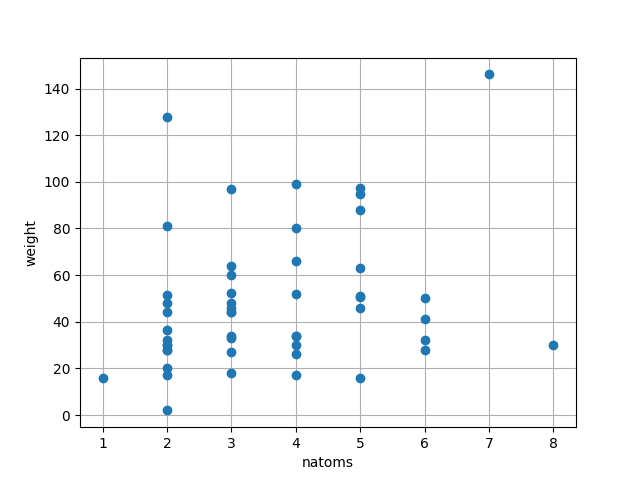

In [18]:
# Plot molecule weight versus number of atoms.

wht,nat = mols_.getcols(['mol.weight','mol.natoms'],IDs=mols_.ids()[:50])

pl.plot(nat,wht,'o')
pl.xlabel('natoms')
pl.ylabel('weight')
pl.grid(True)
pl.show()

In [ ]:
# Get all fileds of an Iso object

iso = query(Isotopologue).first()
iso.dump()

In [ ]:
# List all downloaded isotopologues.

isos_ = Collection(); isos_.update([{'iso':iso} for iso in Isotopologue.all()])
isos_.tabulate(['iso','iso.molecule','iso.abundance','iso.mass'],IDs=isos_.sort(['iso.molecule','iso.mass']))

<IPython.core.display.Javascript object>


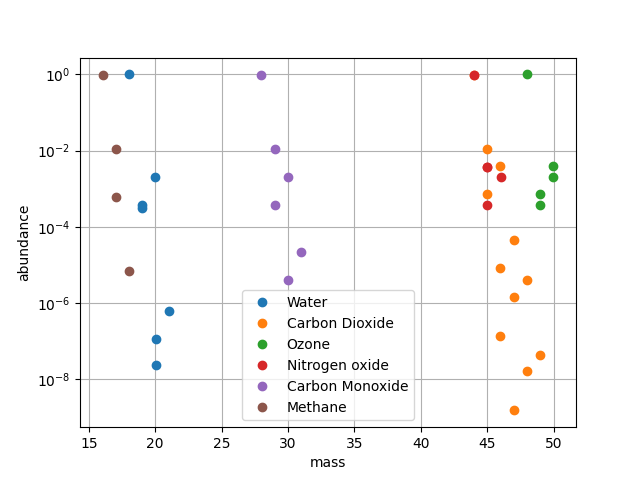

In [26]:
# Plot isotopologue abundances vs mass, group by molecule.

from hapi2.collect import Collection

molnames = ['h2o','co2','o3','n2o','co','ch4']

def plot_isos_abun_vs_weight(mol):
    isos_ = Collection(); isos_.update([{'iso':i} for i in mol.isotopologues])
    abuns,whts = isos_.getcols(['iso.abundance','iso.mass'])
    pl.plot(whts,abuns,'o')
    
leg = []
for mol in [Molecule(m) for m in molnames]:
    plot_isos_abun_vs_weight(mol)
    leg.append(mol)
pl.grid(True)
pl.legend(leg)
pl.yscale('log')
pl.xlabel('mass')
pl.ylabel('abundance')
pl.show()

<IPython.core.display.Javascript object>


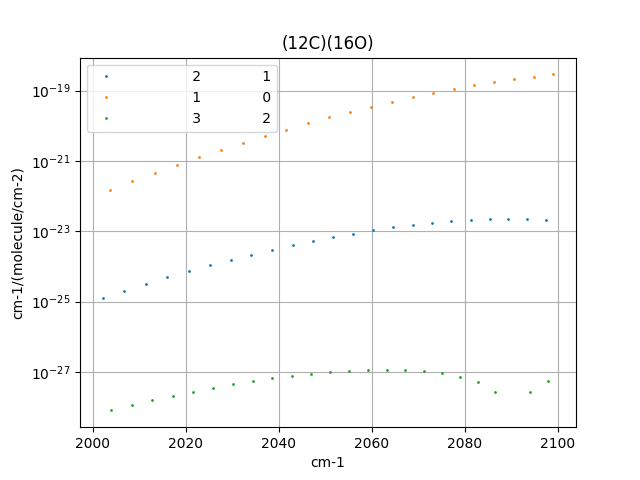

3


In [27]:
# Plot transitions for a given isotopologues grouped by bands.

def plot_bands_for_isotopologue(iso):
    BANDS = {}    
    transs = iso.transitions
    for t in transs:
        key = (t.global_upper_quanta,t.global_lower_quanta)
        if key not in BANDS:
            BANDS[key] = [t]
        else:
            BANDS[key].append(t)
    leg = []
    for key in BANDS:
        tt = BANDS[key]
        leg.append('%s%s'%key)
        nu,sw = list(zip(*[(t.nu,t.sw) for t in tt]))
        pl.plot(nu,sw,'o',markersize=1)
    print(len(leg))
    pl.title(iso)
    pl.xlabel('cm-1')
    pl.ylabel('cm-1/(molecule/cm-2)')
    pl.legend(leg[:10])
    pl.yscale('log')
    pl.grid(True)
    pl.show()

iso = Isotopologue('(12C)(16O)')
plot_bands_for_isotopologue(iso)

<IPython.core.display.Javascript object>


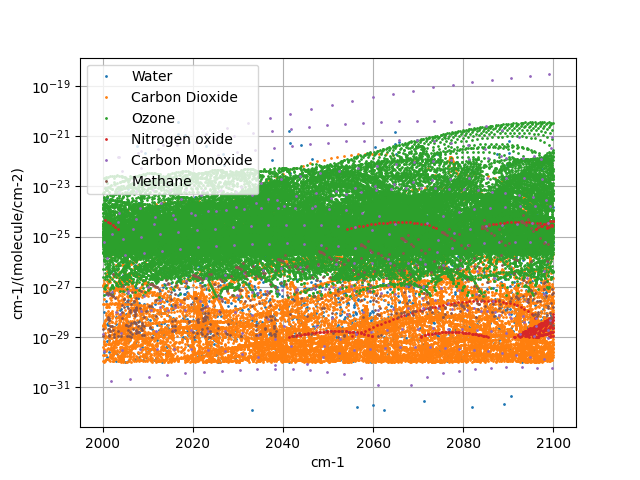

In [28]:
# Plot transitions group by molecules.

def plot_trans_per_molecule(mols):
    leg = []
    for mol in mols:
        leg.append(mol)
        transs = mol.transitions
        nu,sw = list(zip(*[(t.nu,t.sw) for t in transs]))
        pl.plot(nu,sw,'o',markersize=1)
    pl.xlabel('cm-1')
    pl.ylabel('cm-1/(molecule/cm-2)')
    pl.legend(leg[:10])
    pl.yscale('log')
    pl.grid(True)
    pl.show()

mols = [Molecule(m) for m in ['h2o','co2','o3','n2o','co','ch4']]
plot_trans_per_molecule(mols)

In [29]:
# Total number of transitions in the local database.

query(Transition).count()

62685

<IPython.core.display.Javascript object>


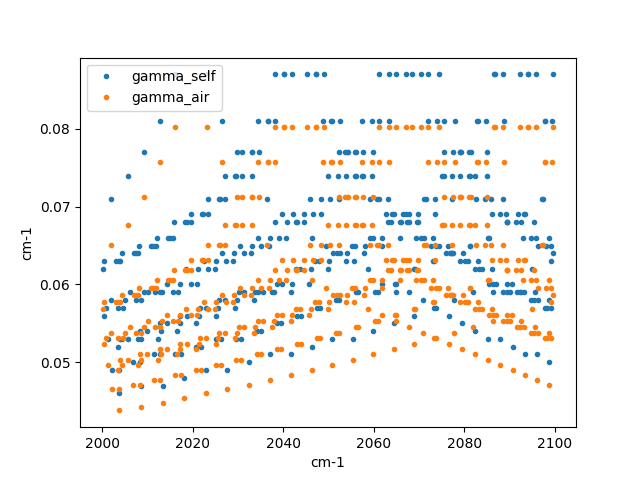

N_trans:  410


In [30]:
# Plot self- and air-broadening parameters for given molecule

molname = 'co'
transs = Molecule(molname).transitions

# get parameters contained in transs
nu,gamma_air,gamma_self = zip(*[(t.nu,t.gamma_air,t.gamma_self) for t in transs])

pl.plot(nu,gamma_self,'.')
pl.plot(nu,gamma_air,'.')
pl.legend(['gamma_self','gamma_air'])
pl.xlabel('cm-1')
pl.ylabel('cm-1')
pl.show()

print('N_trans: ',len(nu))